In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('03_Cleaned_File(Data Preprocessing).csv')

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Gender,Age,EstimatedSalary,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,Exited,Geography_Germany,Geography_Spain
0,15634602,Hargrave,619,0,42,101348.88,0.00,1,1,2,1,1,0,0
1,15647311,Hill,608,0,41,112542.58,83807.86,1,1,1,1,0,0,1
2,15619304,Onio,502,0,42,113931.57,159660.80,3,0,8,0,1,0,0
3,15701354,Boni,699,0,39,93826.63,0.00,2,0,1,0,0,0,0
4,15737888,Mitchell,850,0,43,79084.10,125510.82,1,1,2,1,0,0,1


In [4]:
X = df.drop(columns = ['CustomerId', 'Surname', 'Exited'])
y = df['Exited']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

In [6]:
num_features = ['CreditScore', 'Age', 'EstimatedSalary', 'Balance']
preprocessor = ColumnTransformer(transformers = [('num', StandardScaler(), num_features)],
                                 remainder = 'passthrough',
                                 force_int_remainder_cols=False)

In [7]:
steps = [("preprocess", preprocessor),
         ("adasyn", ADASYN(random_state = 42)),
         ("random_forest", RandomForestClassifier(random_state = 42))]

In [8]:
steps

[('preprocess',
  ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                    transformers=[('num', StandardScaler(),
                                   ['CreditScore', 'Age', 'EstimatedSalary',
                                    'Balance'])])),
 ('adasyn', ADASYN(random_state=42)),
 ('random_forest', RandomForestClassifier(random_state=42))]

In [9]:
pipe = Pipeline(steps)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'EstimatedSalary',
                                                   'Balance'])])),
                ('adasyn', ADASYN(random_state=42)),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [10]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'EstimatedSalary',
                                                   'Balance'])])),
                ('adasyn', ADASYN(random_state=42)),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [11]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [12]:
param_grid = {
    'random_forest__criterion': ['gini', 'entropy'],
    'random_forest__max_depth': [3, 5, 7, 10, 15, 20, None],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__class_weight' : ['balanced']
}

In [13]:
scoring = {
    'accuracy' : 'accuracy',
    'precision' : 'precision',
    'recall' : 'recall',
    'f1' : 'f1'
}

grid_search = GridSearchCV(estimator = pipe,
                           param_grid = param_grid,
                           cv = 5,
                           scoring = scoring,
                           refit = 'recall'
)

In [14]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'EstimatedSalary',
                                                                          'Balance'])])),
                                       ('adasyn', ADASYN(random_state=42)),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__class_weight': ['balanced'],
                         'random_forest__criterion': ['gini', 'entropy'],
                         'random_forest__max_depth': [3, 5, 7, 10, 15, 20,
                                                      None],
                         'random_forest__min_samples_leaf': [1, 2, 4],
                         'random_forest__min_samples_split': [2, 5, 10]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [15]:
grid_search.best_params_

{'random_forest__class_weight': 'balanced',
 'random_forest__criterion': 'entropy',
 'random_forest__max_depth': 3,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2}

In [16]:
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

In [17]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[1916,  473],
       [ 163,  448]], dtype=int64)

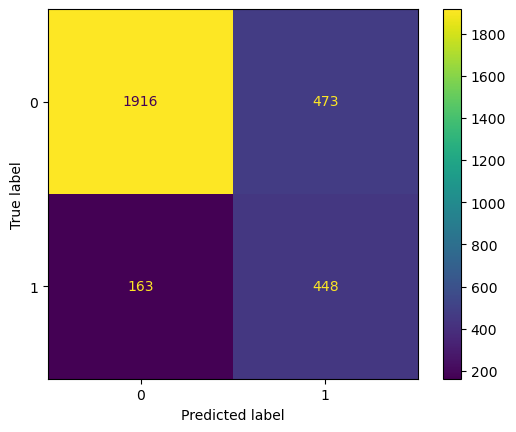

In [18]:
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

In [19]:
class0_accuracy = cm[0,0] / cm[0].sum()
class1_accuracy = cm[1,1] / cm[1].sum()
print(f"Class 0 Accuracy: {class0_accuracy:.2f}")
print(f"Class 1 Accuracy: {class1_accuracy:.2f}")

Class 0 Accuracy: 0.80
Class 1 Accuracy: 0.73


In [20]:
print(f'Accuracy : {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision : {precision_score(y_test, y_pred):.2f}')
print(f'Recall : {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score : {f1_score(y_test, y_pred):.2f}')

Accuracy : 0.79
Precision : 0.49
Recall : 0.73
F1 Score : 0.58


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      2389
           1       0.49      0.73      0.58       611

    accuracy                           0.79      3000
   macro avg       0.70      0.77      0.72      3000
weighted avg       0.83      0.79      0.80      3000

